In [16]:
from settings import *

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

prices는 현재 공휴일이 제외 되지 않았다. 

TODO:

1. 공휴일 제외 데이터를 만들어서(kospi기준) 백테스팅 필요

In [3]:
prices = pd.read_csv('data/dollar_assets.csv', index_col=0, parse_dates=True)
prices.head(1)

,달러,나스닥100,다우
Date,,,
2001-01-02,1278,2128.780,10646.150


<AxesSubplot:xlabel='Date'>

              달러    나스닥100        다우     나스닥100_1      다우_1
Date                                                       
2001-01-02  1278  2128.780 10646.150  2720580.840 44487.180
2001-01-03  1271  2528.380 10945.750  3213570.980 44726.490
2001-01-04  1263  2460.040 10912.410  3107030.520 46491.030
2001-01-05  1263  2267.850 10662.010  2864294.550 43889.250
2001-01-06  1263  2267.850 10662.010  2864294.550 43889.250
...          ...       ...       ...          ...       ...
2020-06-28  1204  9849.360 25015.551 11858629.440 47919.200
2020-06-29  1200  9961.160 25595.801 11953392.000 49176.000
2020-06-30  1199 10156.850 25812.881 12178063.150 48871.240
2020-07-01  1202 10279.250 25734.971 12355658.500 48981.500
2020-07-02  1199 10341.890 25827.359 12399926.110 49866.410

[7122 rows x 5 columns]


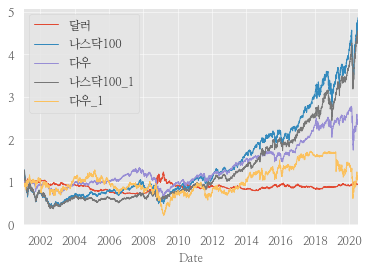

In [30]:
p = pd.read_csv('data/assets.csv', index_col=0, parse_dates=True)
df = prices.copy()
df['나스닥100_1'] = p['나스닥100']*prices['달러']
df['다우_1'] = p['다우']*prices['달러']

df.dropna().rebase(1).plot();
print(df)

In [31]:
data = pd.read_csv("/Users/hosung/workspace/git/docu/data/asset_db.csv", index_col=0, parse_dates=True)
data.sample()

,kbond20y,vn30,kbond1y,uscorp15_UH,usenergy_UH,usdkrw,usbond30y_H,kbond10y,eurkrw,em_H,topx100,nasdaq100_H,cnykrw,world_UH,csi300,us500_UH,dji_UH,gold_H,kodex200x2,jpykrw,nasdaq100_UH,reit_H,kbond3y,kodex200,copper_UH,us500_H,usbond10y_UH
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,
1995-07-11,4876.653,nan,37183.145,20965.889,nan,757.350,3125.710,17685.453,998.340,nan,7182.787,1233.059,92.870,1960.488,281.264,668.980,1213.601,2691.146,14503.925,8.648,1830.672,868.694,29891.513,7515.627,4881.302,4339.597,2546.265


<AxesSubplot:xlabel='Date'>

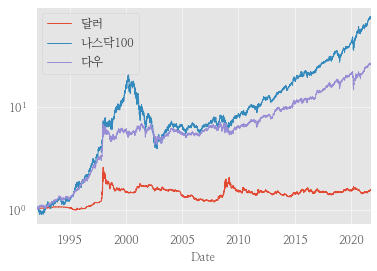

In [57]:
prices = data[['usdkrw', 'nasdaq100_UH', 'dji_UH']].copy()
prices.columns = ['달러','나스닥100','다우']
prices = prices.resample('D').first().fillna(method="ffill")
prices.dropna().rebase(1).plot(logy=True)
prices = prices['2001-01-02':'2020-07-02']
prices.to_csv("dollar_assets.csv")

In [49]:
def AMS(x):
    ''' x : Series (DataFrame의 컬럼)
        x[-1] : 기준일. x의 현재값
        (오늘날짜/과거날짜 - 1) > 0 보다 크면 1, 아니면 0
        => 오늘날짜/과거날짜 > 1 => 오늘날짜 > 과거날짜  => x[-1] > x
    '''
    # print(f"{list(np.where(x[-1]>x, 1, 0)[:-1])}, {len(np.where(x[-1]>x, 1, 0)[:-1])}")
    return np.mean(np.where(x[-1]>x, 1, 0)[:-1]) # 당일 날짜 비교는 제외해준다 [:-1]    

In [50]:
target_weights = pd.DataFrame()
for c in ["나스닥100", "다우"]:
    target_weights[c] = prices[c].rolling(365).apply(AMS)
target_weights = target_weights*0.5
target_weights['달러'] = 1.0 - target_weights.sum(axis=1)

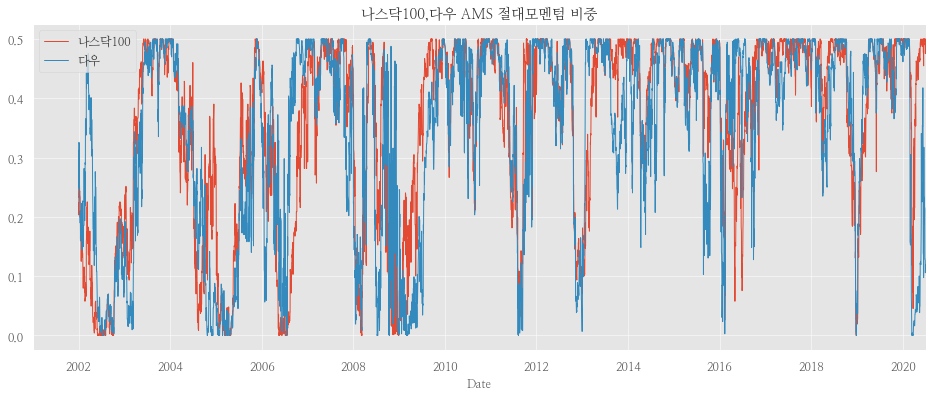

In [51]:
target_weights[['나스닥100', '다우']].plot(figsize=(16,6), title='나스닥100,다우 AMS 절대모멘텀 비중', legend=True);

In [52]:
tickers = prices.columns

In [53]:
나스닥다우동일비중 =bt.Strategy(
    "나스닥다우동일비중",
    [
        bt.algos.RunAfterDate('2002-1-2'),
        bt.algos.RunMonthly(),
        bt.algos.SelectThese(['나스닥100', '다우']),
        bt.algos.WeighEqually(),
#         bt.algos.PrintTempData(),
        bt.algos.Rebalance()
    ]
)

In [54]:
나스닥다우동일비중AMS = bt.Strategy(
    '나스닥다우동일비중AMS',
    [
        bt.algos.RunAfterDate('2002-1-2'),
        bt.algos.RunMonthly(),
        bt.algos.SelectThese(['나스닥100', '다우', '달러']),
        bt.algos.WeighTarget(target_weights),
        # WeighEquallyWithoutCash(target_weights, cash='현금'),
#         bt.algos.PrintTempData(),
        bt.algos.Rebalance()
    ]
)

In [55]:
bt_나스닥다우동일비중 = bt.Backtest(나스닥다우동일비중, prices)
bt_나스닥다우동일비중AMS = bt.Backtest(나스닥다우동일비중AMS,  prices)
r = bt.run(bt_나스닥다우동일비중, bt_나스닥다우동일비중AMS)

In [56]:
r.set_date_range("2002-02-01") 
r.display()

Stat                 나스닥다우동일비중    나스닥다우동일비중AMS
-------------------  --------------------  -----------------------
Start                2002-02-01            2002-02-01
End                  2020-07-02            2020-07-02
Risk-free rate       0.00%                 0.00%

Total Return         356.85%               187.02%
Daily Sharpe         0.43                  0.40
Daily Sortino        0.67                  0.61
CAGR                 8.60%                 5.89%
Max Drawdown         -42.81%               -22.90%
Calmar Ratio         0.20                  0.26

MTD                  1.78%                 1.55%
3m                   25.04%                9.85%
6m                   6.67%                 0.68%
YTD                  6.45%                 0.48%
1Y                   16.64%                9.08%
3Y (ann.)            16.74%                10.40%
5Y (ann.)            15.54%                9.16%
10Y (ann.)           15.66%                10.21%
Since Incep. (ann.)  8.60%            

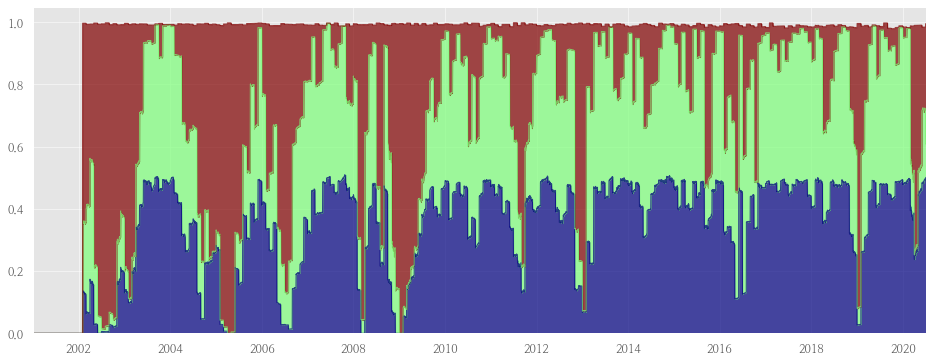

In [58]:
r.get_security_weights('나스닥다우동일비중AMS').plot.area(stacked=True, alpha=0.7, legend=False, cmap='jet', figsize=(16,6));

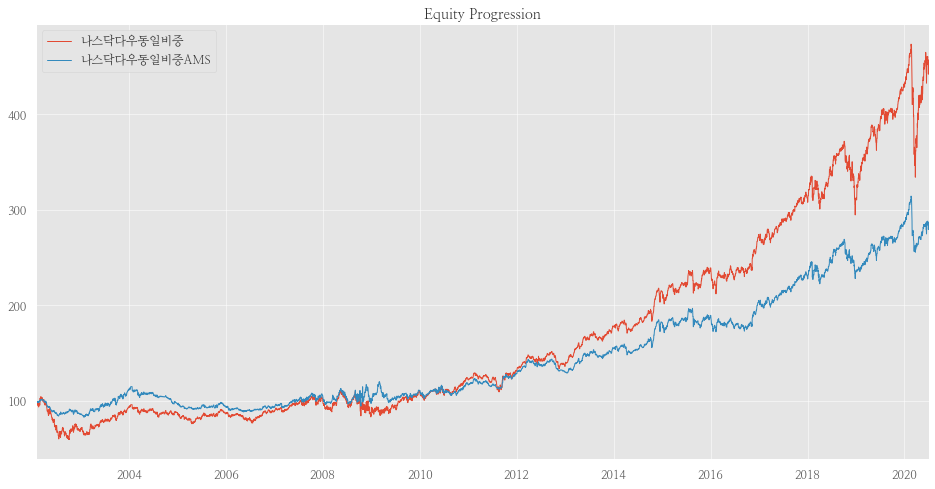

In [59]:
ax = r.plot(figsize=(16,8));
plt.legend(loc="upper left");

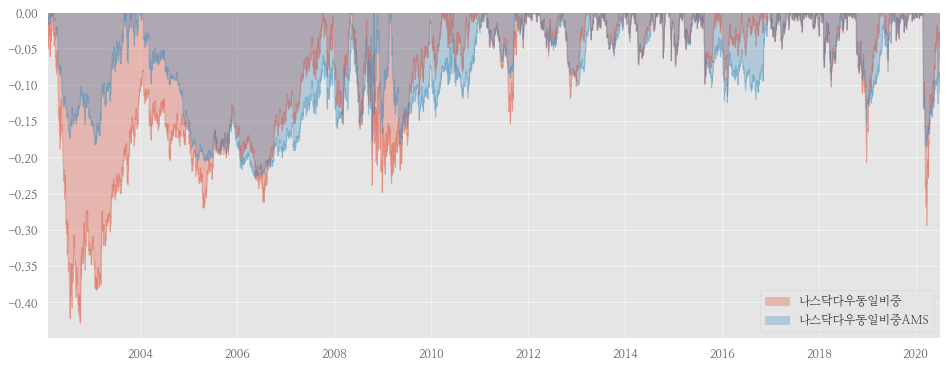

In [60]:
r.prices.to_drawdown_series().plot.area(stacked=False, alpha=0.3, figsize=(16, 6));

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2002-02-02  2002-02-02
End Period                 2020-07-02  2020-07-02
Risk-Free Rate             0.0%        0.0%
Time in Market             69.0%       68.0%

Cumulative Return          187.02%     356.85%
CAGR﹪                     5.89%       8.59%

Sharpe                     0.4         0.43
Smart Sharpe               0.36        0.39
Sortino                    0.57        0.62
Smart Sortino              0.52        0.56
Sortino/√2                 0.4         0.44
Smart Sortino/√2           0.36        0.4
Omega                      1.1         1.1

Max Drawdown               -22.9%      -42.81%
Longest DD Days            1763        2037
Volatility (ann.)          11.55%      16.53%
R^2                        0.7         0.7
Calmar                     0.26        0.2
Skew                       0.38        0.75
Kurtosis                   34.68       22.16

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2004-01-27,2006-05-17,2008-11-24,1763,-22.901,-22.231
2,2020-02-21,2020-03-23,2020-07-02,132,-18.653,-18.079
3,2002-03-20,2003-01-27,2003-09-04,533,-18.277,-17.823
4,2009-03-03,2009-05-13,2011-02-09,708,-18.134,-17.051
5,2008-11-25,2008-12-29,2009-02-20,87,-16.767,-16.737


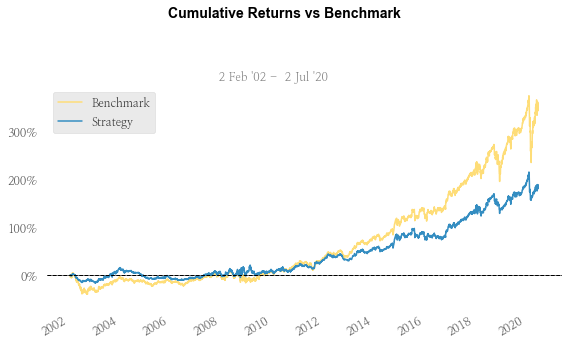

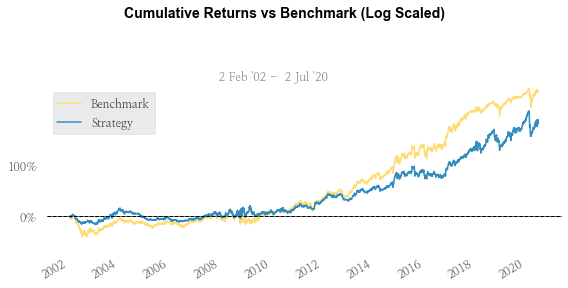

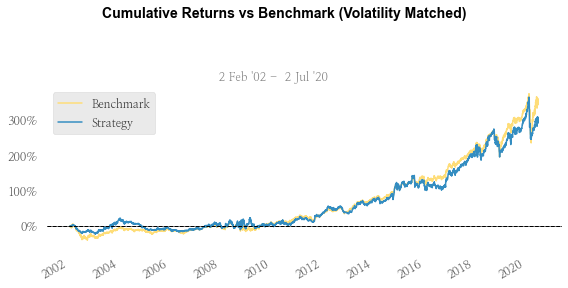

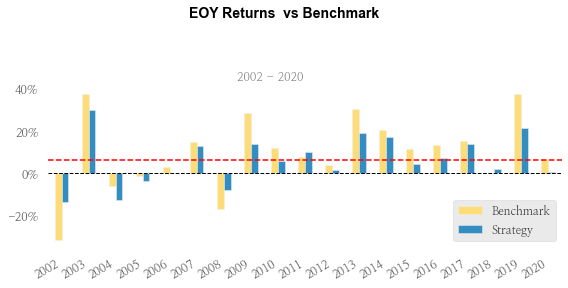

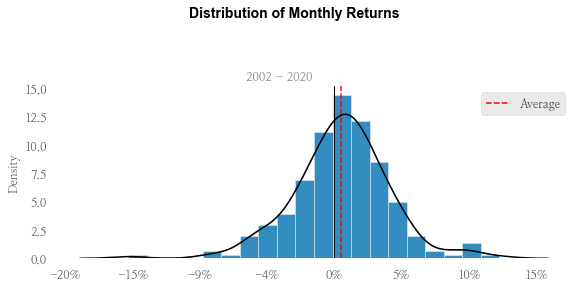

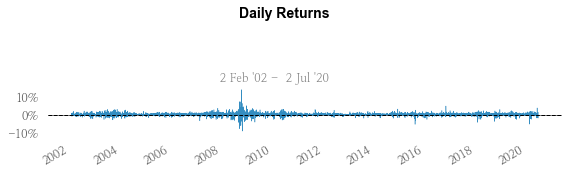

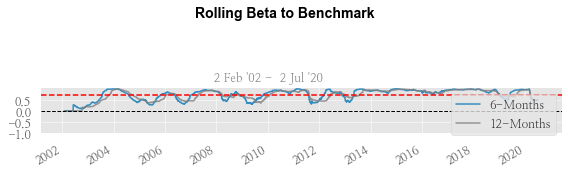

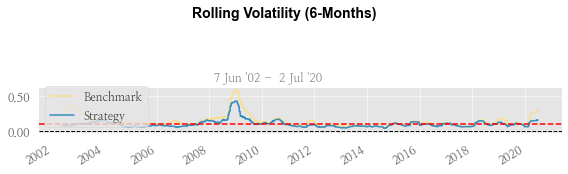

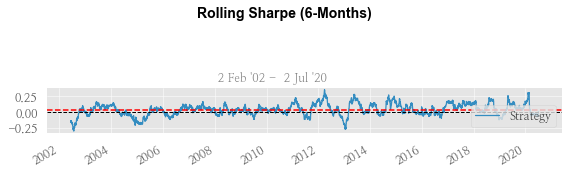

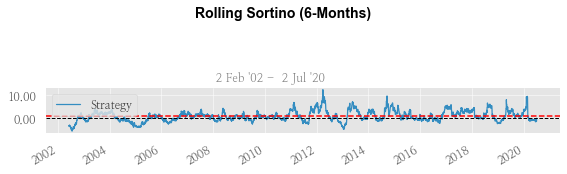

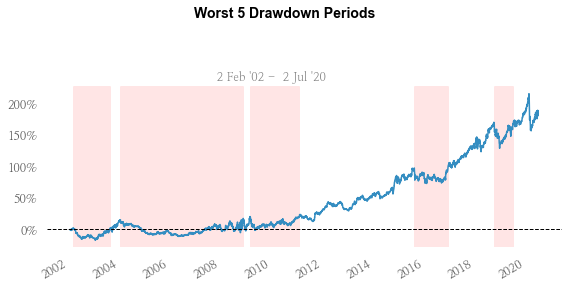

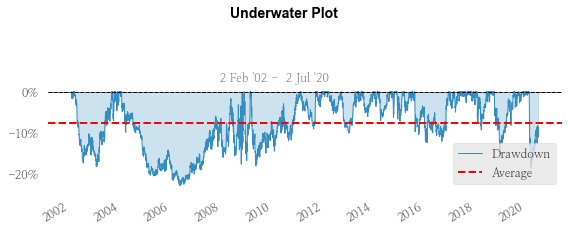

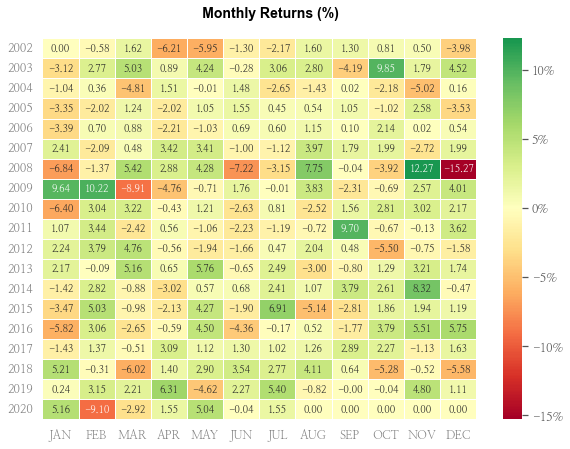

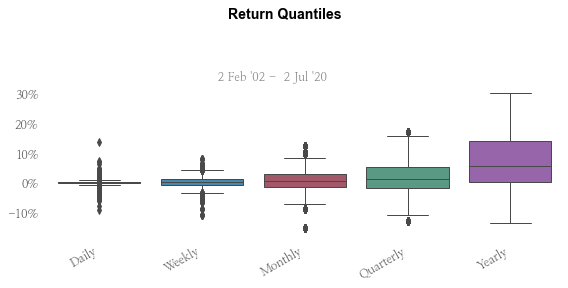

In [61]:
qs.reports.full(r['나스닥다우동일비중AMS'].prices.to_returns().dropna(), 
                r['나스닥다우동일비중'].prices.to_returns().dropna())